## Importing Packages and Defining Vector Field Visualization Function

In [99]:
## Vector Field Visualization
println("Loading packages...")
using GLMakie, GeometryBasics, LinearAlgebra
println("Packages loaded successfully.")

cd(@__DIR__) # Changing the current working directory from project root to the parent directory of this file so that pwd() and @__DIR__ match.
# Import custom code and utility functions
include("../src/Rendering.jl")


# Initialize the custom structs and utilities
renderer = Renderer()


function exponential_spacing(min_val::Real, max_val::Real, resolution::Int; base::Real=ℯ)
    if resolution == 1
        return [(min_val + max_val) / 2]
    end
    if base < 0
        throw(ArgumentError("Base must be greater than 0 for exponential spacing."))
    end
    if base == 1
        return range(min_val, max_val, length=resolution) # Linear spacing if base is 1
    end
    
    # Create linear range from min to max
    linear_points = range(min_val, max_val, length=resolution)
    
    # Define casewise exponential function with custom base
    function f(x)
        if x > 0
            # For positive values: exponential decay towards zero
            # Maps [0, max] to [0, max] with more points near zero
            return max_val * (base^(x/max_val) - 1) / (base - 1)
        elseif x < 0
            # For negative values: exponential decay towards zero
            # Maps [min, 0] to [min, 0] with more points near zero
            return min_val * (base^(-x/(-min_val)) - 1) / (base - 1)
        else
            # x == 0
            return 0.0
        end
    end
    
    # Apply the exponential transformation
    exponential_points = [f(x) for x in linear_points]
    
    return exponential_points
end

function visualize_vector_field!(
    scene::Scene,     
    field::Function;
    bounds::Union{AbstractVector{<:AbstractVector{<:Real}}, AbstractVector{<:Real}, Real}=[[-5, 5], [-5, 5], [-5, 5]], # example: [[-10, 10], [-10, 10], [-10, 10]]
    resolution::Union{Int, AbstractVector{<:Int}}=5,
    color::Union{GLMakie.Colorant, Nothing}=nothing,
    scale::Real=1.0,
    custom_arrows::Bool=false,
    base::Real=1.0,
    center::Point3{Float64}=Point3{Float64}(0.0, 0.0, 0.0), # Center of the scene for camera positioning,
    normalization_condition::Bool=true # Normalize the vector field if true
    )

    if typeof(bounds) <: Real
        @assert bounds > 0 "Bounds must be a positive number when it's a single value for a symmetric visualization."
        bounds = [[-bounds, bounds], [-bounds, bounds], [-bounds, bounds]] # Convert single Real to 3D bounds
    elseif typeof(bounds) <: AbstractVector{<:Real}
        @assert length(bounds) == 3 "Bounds must be a vector of 3 AbstractVectors: x, y, and z bounds."
        @assert all(x -> x> 0, bounds) "Each bound must be a positive number or a vector of two positive numbers."
        bounds = [[-bounds[1], bounds[1]], [-bounds[2], bounds[2]], [-bounds[3], bounds[3]]] # Convert 2D to 3D bounds
    end

    # Assertions to ensure the bounds are correctly defined
    for bound in bounds
        @assert length(bound) == 2 "Each bound must be an AbstractVector of length 2: start and end. (e.g., [-10, 10])"
    end
    @assert length(bounds) == 3 "Bounds must be a vector of 3 AbstractVectors: x, y, and z bounds."
    @assert typeof(resolution) <: Integer || (typeof(resolution) <: AbstractVector && all(x -> x > 0, resolution) && length(resolution) == 3) "Resolution must be a positive integer or a vector of positive integers, corresponding to the x, y, and z dimensions."

    # Create a grid of points in the specified bounds
    if typeof(resolution) <: Integer
        resolution = [resolution, resolution, resolution] # Convert to a vector of 3 integers
    end
    
    # Fix: Ensure consistent array types for all dimensions
    x = resolution[1] != 1 ? exponential_spacing(bounds[1][1], bounds[1][2], resolution[1]; base=base) : [(bounds[1][1] + bounds[1][2])/2]
    y = resolution[2] != 1 ? exponential_spacing(bounds[2][1], bounds[2][2], resolution[2]; base=base) : [(bounds[2][1] + bounds[2][2])/2]
    z = resolution[3] != 1 ? exponential_spacing(bounds[3][1], bounds[3][2], resolution[3]; base=base) : [(bounds[3][1] + bounds[3][2])/2]

    x = [center[1] + xi for xi in x] # Center the grid around the specified center point
    y = [center[2] + yi for yi in y] # Center the grid around the specified center point
    z = [center[3] + zi for zi in z] # Center the grid around the specified center point

    # Generate the vector field
    # Fix: Correct NaN checking and mapping function
    mapping(i) = isnan(i) ? 1 : clamp(round(Int, 255*2*atan(i/2)/pi) + 1, 1, 256)
    viridis = GLMakie.cgrad(:viridis) # Creates a color map (a list of colors of length 256 with colors ranging from blue to yellow)
    
    arrows = Vector{Arrow}()
    arrow_colors = Vector{GLMakie.Colorant}()
    for xi in x, yi in y, zi in z
        f = field(xi, yi, zi)
        arrow_length = norm(f)
        
        # Fix: Handle zero-length vectors properly
        if isapprox(arrow_length*scale, 0.0, atol=1e-10) || isnan(arrow_length)
            # Skip zero-length vectors or use a default direction
            continue
        end
        if custom_arrows
            arrow_to_body_ratio = (1 - exp(-sqrt(arrow_length)) + 2 / 3 + exp(-1 / sqrt(arrow_length)) / 3) / 2
            shaft_length = Float64(arrow_to_body_ratio) * arrow_length
            head_length = arrow_length - shaft_length
            shaft_radius = head_length / 5 / 7.5
            head_radius = shaft_radius * 1.75
            push!(arrows, Arrow(Point3{Float64}(xi, yi, zi), normalization_condition == true ? normalize(Vec3{Float64}(f)).*(scale*2*atan(arrow_length/2)/pi) : Vec3{Float64}(f).*scale, shaft_radius=shaft_radius, head_radius=head_radius, arrow_to_body_ratio=0.75))
        else
            push!(arrows, Arrow(Point3{Float64}(xi, yi, zi), normalization_condition == true ? normalize(Vec3{Float64}(f)).*(scale*2*atan(arrow_length/2)/pi) : Vec3{Float64}(f).*scale))
        end
        if isnothing(color)
            push!(arrow_colors, viridis[mapping(arrow_length)])
        else
            push!(arrow_colors, color)
        end
    end

    arrow_meshes = []
    for i in eachindex(arrows)
        m = mesh!(scene, arrows[i].mesh; color=arrow_colors[i])
        push!(arrow_meshes, m)
    end

    display(scene)
    return arrow_meshes
end

# Define the vector field visualization function
"""
    visualize_vector_field(field::Function; bounds=[[-5, 5], [-5, 5], [-5, 5]], resolution=5, color=nothing, scale=1.0)
"""
function visualize_vector_field(
    field::Function;
    bounds::Union{AbstractVector{<:AbstractVector{<:Real}}, AbstractVector{<:Real}, Real}=[[-5, 5], [-5, 5], [-5, 5]], # example: [[-10, 10], [-10, 10], [-10, 10]]
    resolution::Union{Int, AbstractVector{<:Int}}=5,
    color::Union{GLMakie.Colorant, Nothing}=nothing,
    scale::Real=1.0,
    custom_arrows::Bool=false,
    base::Real=1.0,
    center::Point3{Float64}=Point3{Float64}(0.0, 0.0, 0.0), # Center of the scene for camera positioning,
    normalization_condition::Bool=true # Normalize the vector field if true
    )

    # Create a scene and add the arrows
    scene = Scene(camera=cam3d!)
    arrow_meshes = visualize_vector_field!(
        scene,
        field;
        bounds=bounds,
        resolution=resolution,
        color=color,
        scale=scale,
        custom_arrows=custom_arrows,
        base=base,
        center=center,
        normalization_condition=normalization_condition
    )

    return scene, arrow_meshes
end

println("Vector field visualization function defined successfully.")

Loading packages...
Packages loaded successfully.
Vector field visualization function defined successfully.


---

### Enter A Custom Function F(x,y,z) to visualize it for given bounds and resolution

In [266]:
F(x, y, z) = (x^2 - y^2, 2*x*y, z) # Example vector field function

F (generic function with 1 method)

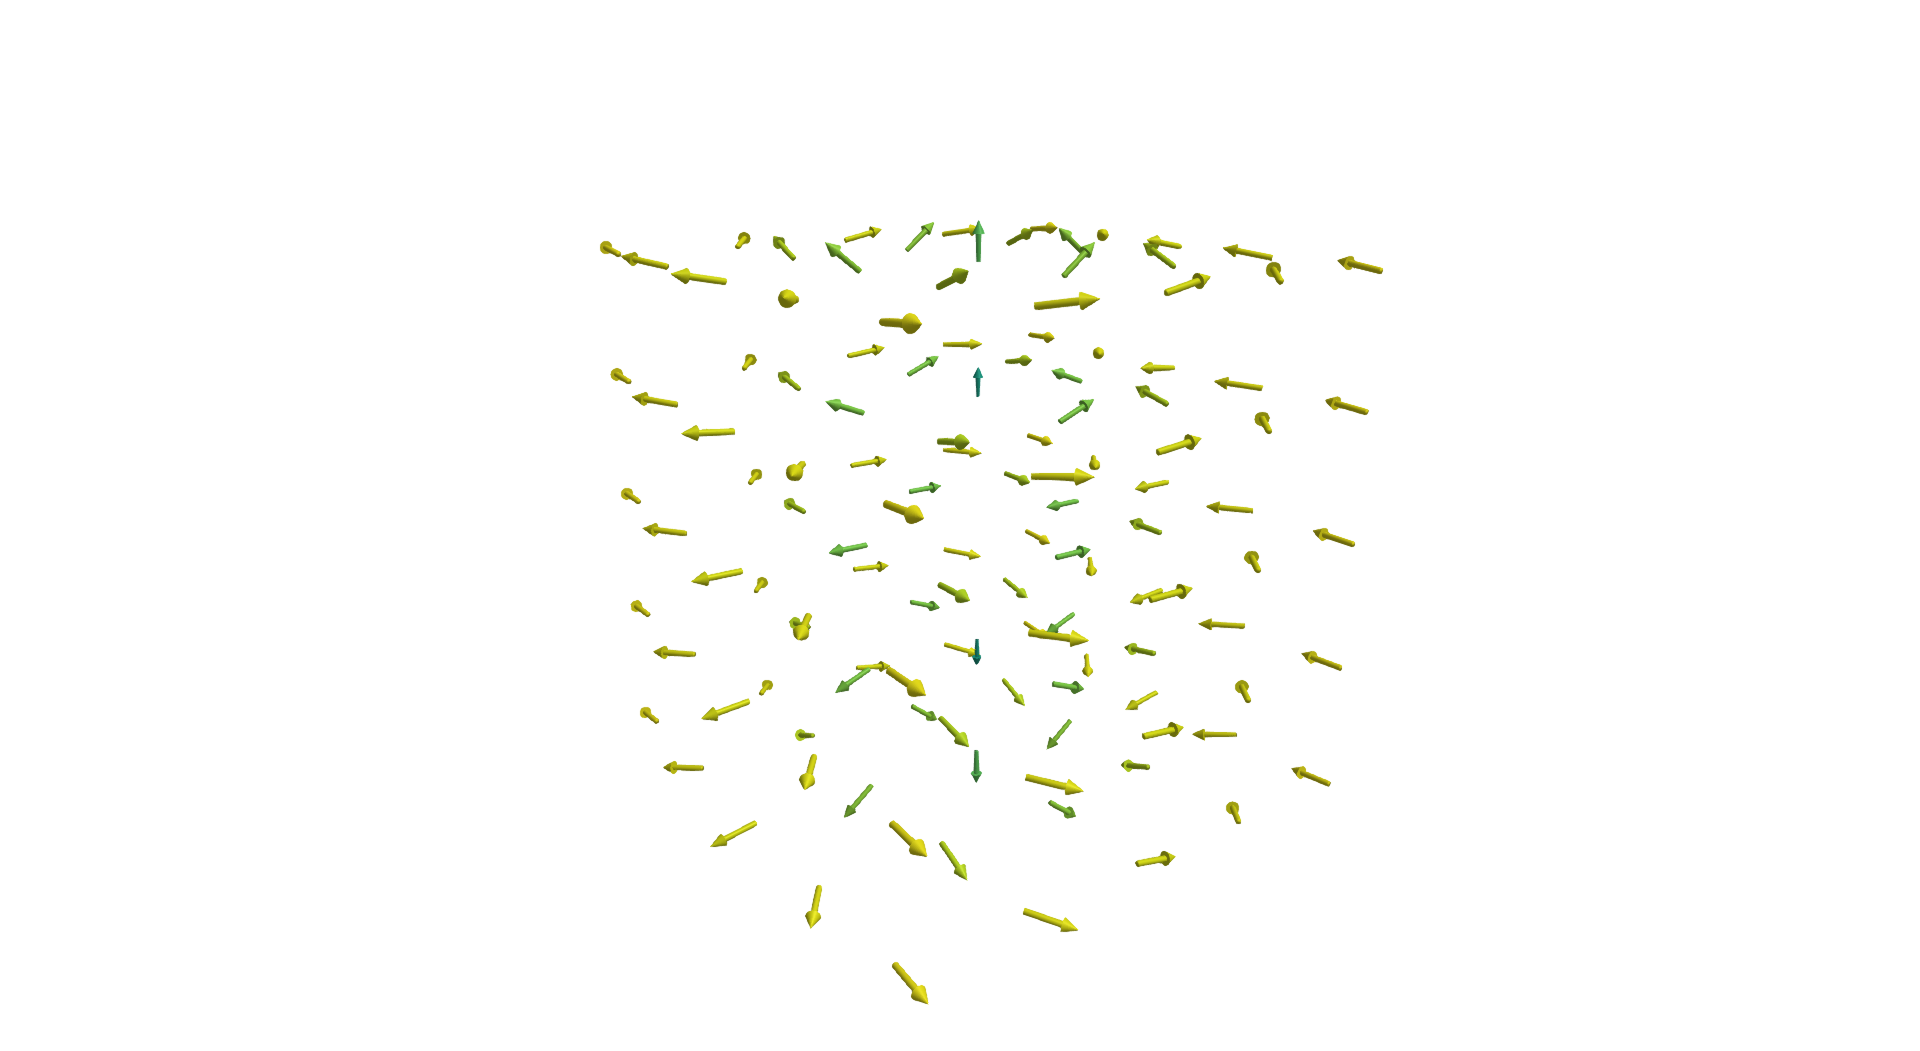

GLMakie.Screen(...)

In [267]:
GLMakie.Makie.inline!(false)
s, a = visualize_vector_field(F)
display(s)
sleep(10) # Let user set the camera position before the script ends

GLMakie.Makie.inline!(true) # Re-enable inline rendering for subsequent plots
display(s) # Render the image inline 

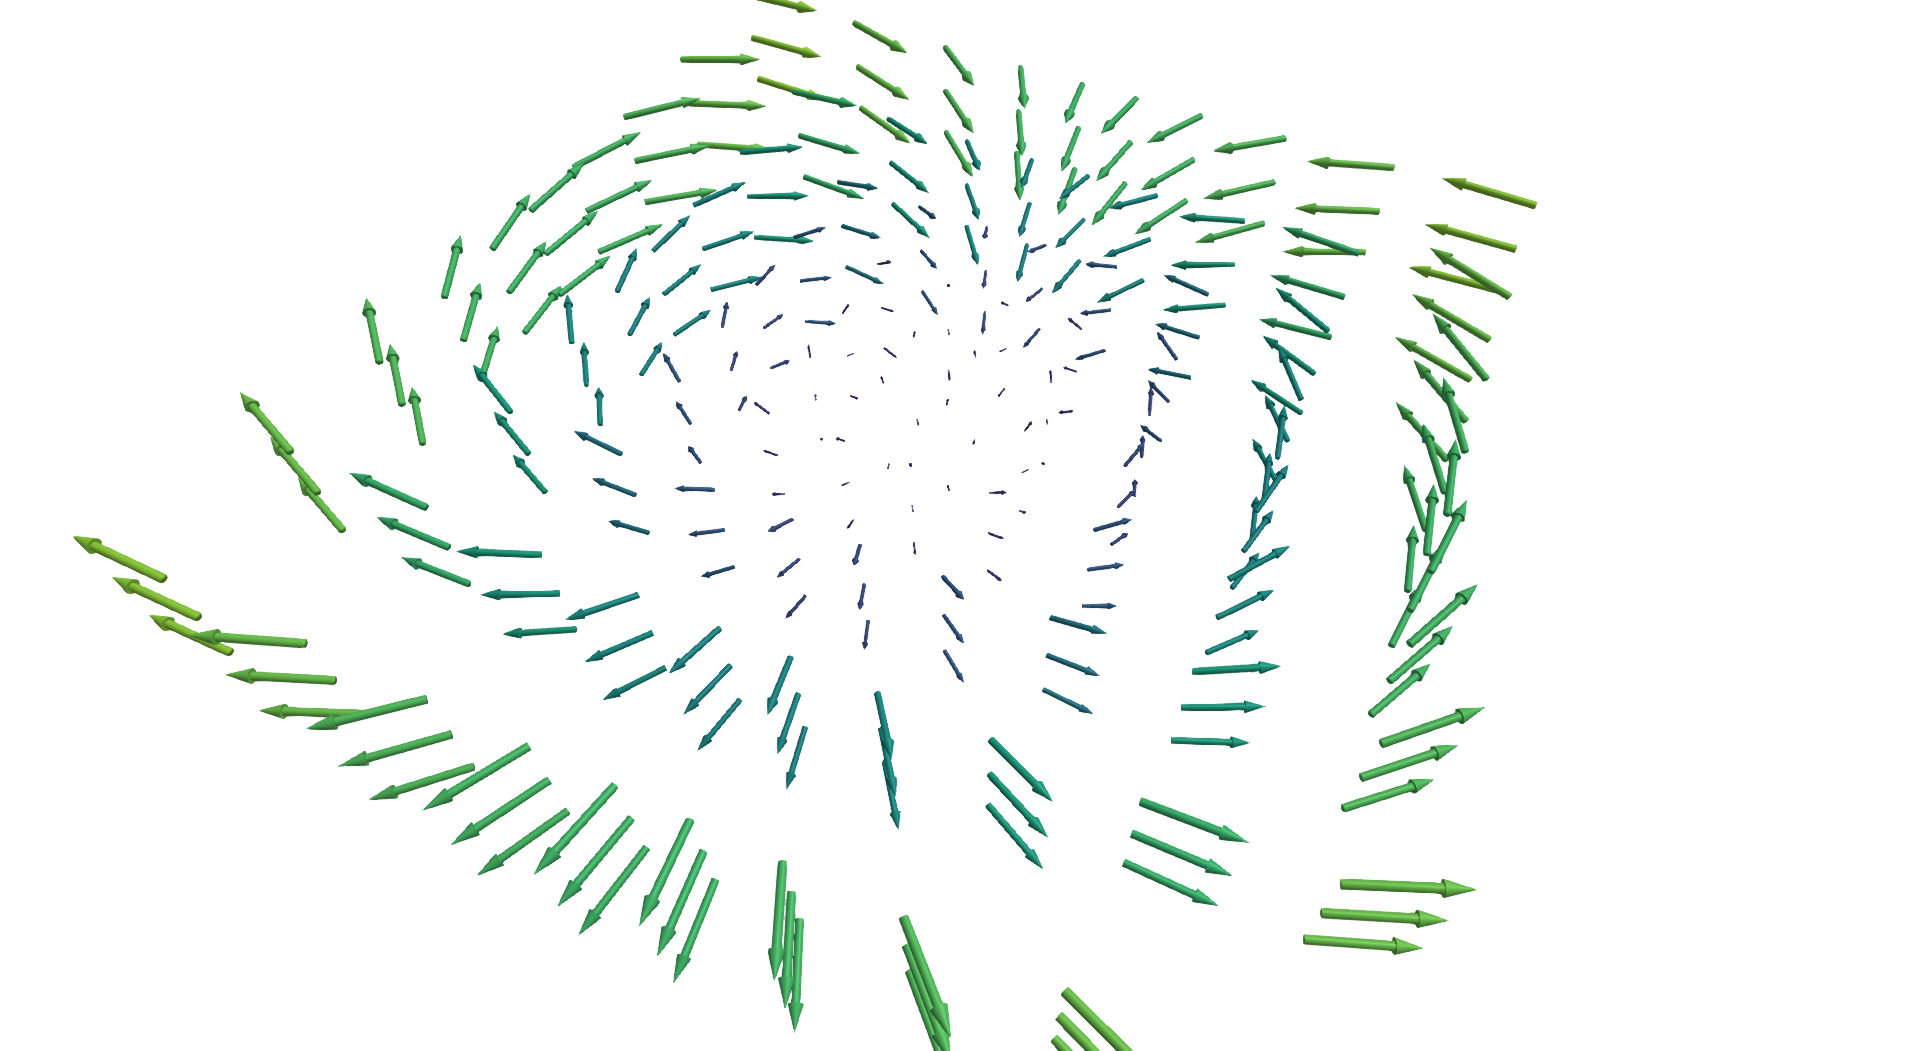

GLMakie.Screen(...)

In [195]:
GLMakie.Makie.inline!(false) 
# You can use different parameters for the visualization
s, a = visualize_vector_field(F; resolution=[10,10,3], bounds=[2,2,0.25], scale=0.5, base=ℯ, custom_arrows=true) # Try Changing resolution, bounds, scale, base and custom_arrows
display(s)
sleep(10) # Let user set the camera position before the script ends

GLMakie.Makie.inline!(true) # Re-enable inline rendering for subsequent plots
display(s) # Render the image inline 

---

## Defining the Velocity functions for Vortex Filament Method

`velocity` function is from the Notes whereas `velocity2` is what I derived by hand

In [2]:
function velocity(r::AbstractVector{<:Real}, R1::AbstractVector{<:Real}, R2::AbstractVector{<:Real}, Gamma::Real)
    #https://www.tfd.chalmers.se/~lada/postscript_files/Licentiate_thesis_Hamid.pdf
    @assert length(r) == 3 "Position vector r must be a 3D vector."
    @assert length(R1) == 3 "Position vector R1 must be a 3D vector."
    @assert length(R2) == 3 "Position vector R2 must be a 3D vector."

    R1r = r - R1
    R2r = r - R2

    K12 = dot(-Gamma * (R2 - R1) / (4 * pi * norm(cross(R1r, R2r))^2), (normalize(R2r) - normalize(R1r)))
    v = K12 * cross(R1r, R2r)

end

function velocity2(r::AbstractVector{<:Real}, R1::AbstractVector{<:Real}, R2::AbstractVector{<:Real}, Gamma::Real)
    # A different function definition - Derivation is in my Notes
    @assert length(r) == 3 "Position vector r must be a 3D vector."
    @assert length(R1) == 3 "Position vector R1 must be a 3D vector."
    @assert length(R2) == 3 "Position vector R2 must be a 3D vector."

    h = r - R1
    L = R2 - R1
    h_dot_L = dot(h, L)
    h_cross_L = cross(h, L)

    prefactor = Gamma / (4 * pi) * (-h_cross_L) * (1/norm(h_cross_L)^2)
    term1 = (norm(L)^2 - h_dot_L)/norm(h-L) 
    term2 = h_dot_L/norm(h)
    v = prefactor * (term1 + term2)
    return v
end

velocity2 (generic function with 1 method)

In [3]:
F1(x,y,z) = velocity(Point3{Float64}(x, y, z), Point3{Float64}(0.0, 0.0, 0.0), Point3{Float64}(0.0, 0.0, 1.0), 100.0)
F2(x,y,z) = velocity2(Point3{Float64}(x, y, z), Point3{Float64}(0.0, 0.0, 0.0), Point3{Float64}(0.0, 0.0, 1.0), 100.0)
F(x,y,z) = F1(x,y,z) + F2(x,y,z)

F (generic function with 1 method)

In [159]:
F_diff(x,y,z) = F1(x,y,z) - F2(x,y,z)
difference = [F_diff([rand(3)...].*rand(Int8)...) for i in 1:1000]
diff = zeros(length(difference))
for i in eachindex(difference)
    if isnan(difference[i][1]) || isnan(difference[i][2]) || isnan(difference[i][3]) 
        diff[i] = 0 # Handle NaN values by replacing them with zero vectors
    else
        diff[i] = norm(difference[i]) # Ensure we are storing the magnitude of the vector
    end
end
println("The Maximum difference within a sample of $(length(difference)) datapoints is: ", maximum(diff))

The Maximum difference within a sample of 1000 datapoints is: 7.944109290391274e-15


We can thus conclude that both the functions are the same

In [177]:
using BenchmarkTools
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 60*10 # Set the default max benchmark duration to 10 minutes

600

In [178]:
@benchmark F1([rand(3)...].*rand(Int8)...) samples = 1000000

BenchmarkTools.Trial: 1000000 samples with 120 evaluations per sample.
 Range (min … max):  442.500 ns … 489.486 μs  ┊ GC (min … max): 0.00% … 99.63%
 Time  (median):     787.500 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   930.353 ns ±   2.985 μs  ┊ GC (mean ± σ):  7.25% ±  2.31%

  ▂▂▂▂▂▂▂▂▂▂▂▆█▆▅▅▄▄▅▄▄▄▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁                     ▃
  █████████████████████████████████████████████████████████████ █
  442 ns        Histogram: log(frequency) by time       2.12 μs <

 Memory estimate: 368 bytes, allocs estimate: 13.

In [179]:
@benchmark F2([rand(3)...].*rand(Int8)...) samples = 1000000


BenchmarkTools.Trial: 1000000 samples with 125 evaluations per sample.
 Range (min … max):  626.400 ns … 450.406 μs  ┊ GC (min … max): 0.00% … 99.64%
 Time  (median):     781.600 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   928.136 ns ±   2.900 μs  ┊ GC (mean ± σ):  7.24% ±  2.36%

       ██▆▅▅▅▄▆▄▄▅▄▃▃▃▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁     ▄
  ▅▄▅▅█████████████████████████████████████████████████████████ █
  626 ns        Histogram: log(frequency) by time       2.14 μs <

 Memory estimate: 368 bytes, allocs estimate: 13.

So essentially, both functions are equivalent and have similar efficiency.

---

Now, how do the fields from these functions look like?

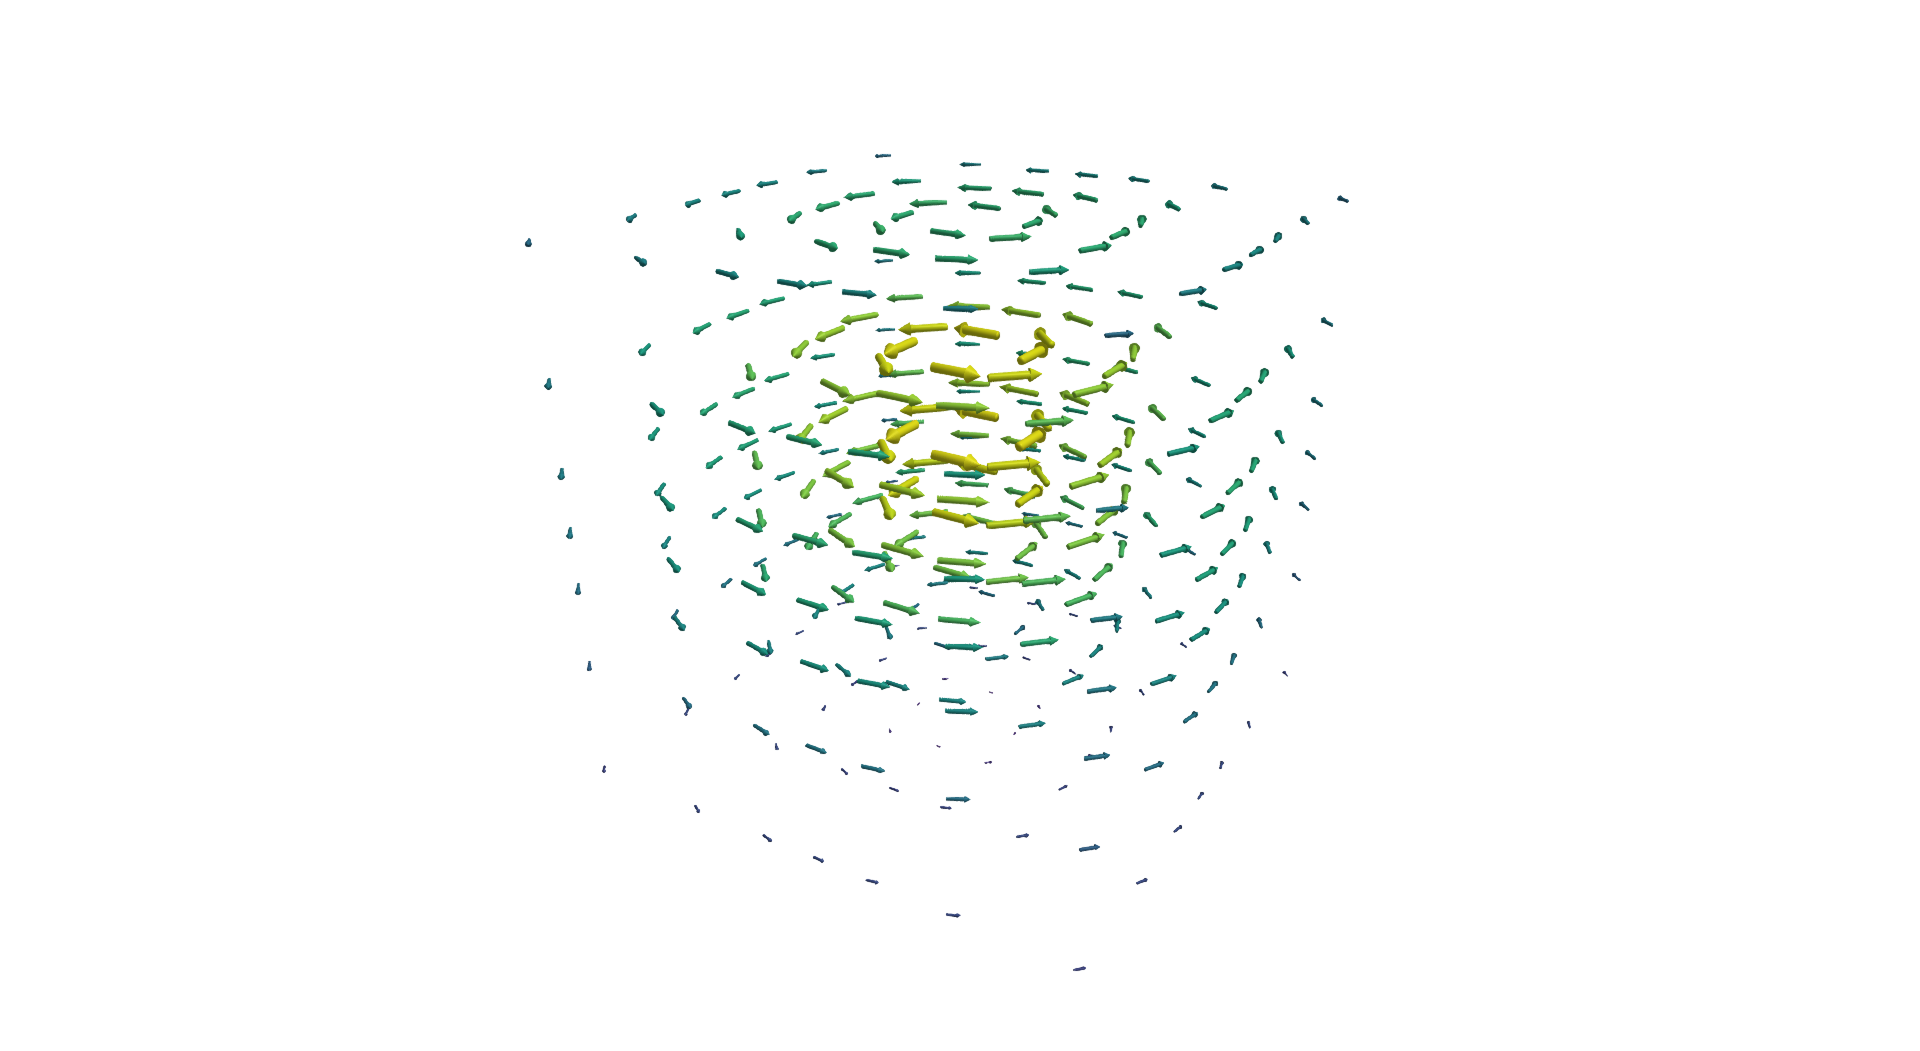

GLMakie.Screen(...)

In [ ]:
GLMakie.Makie.inline!(false)
s, a = visualize_vector_field(F1; custom_arrows=true, bounds=1.5, resolution=7, scale=0.3, base=3)
display(s)
sleep(10) # Let user set the camera position before the script ends

GLMakie.Makie.inline!(true) # Re-enable inline rendering for subsequent plots
display(s) # Render the image inline 

## Updated Biot-Savart Law for Vortex Filament

Notice how the velocities at the vortex filament itself diverge to infinity.
To not have this behaviour, we assume for this variant of the Biot-Savart law that the vortex line has a certain width. 

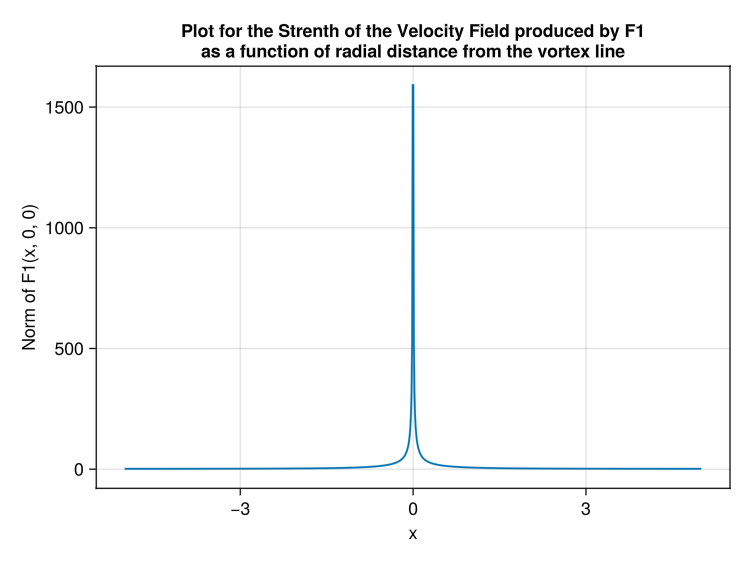

In [232]:
# Plot current graph for x vs norm(F1(x.*[1,0,0]))
x_vals = exponential_spacing(-5, 5, 1000; base=1)
y_vals = [norm(F1(x, 0, 0)) for x in x_vals]
GLMakie.Makie.inline!(true)
lines(
    x_vals, 
    y_vals; 
    axis=(
        # aspect=DataAspect(), 
        # yreversed=true,
        title="Plot for the Strenth of the Velocity Field produced by F1\nas a function of radial distance from the vortex line",
        xlabel="x",
        ylabel="Norm of F1(x, 0, 0)",
        )
    )

We would like strength of the velocity field within a certain radius of the vortex line to be linearly decreasing to zero. Just the way $\vec{B}$ fields (Magnetic Fields) behave for a wire with finite thickness. (The general motivation being that both Vector Fields are Isomorphic).

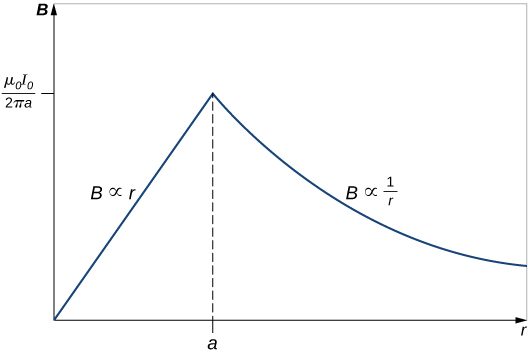

>source: [LibreText Physics](https://phys.libretexts.org/Bookshelves/University_Physics/University_Physics_%28OpenStax%29/University_Physics_II_-_Thermodynamics_Electricity_and_Magnetism_%28OpenStax%29/12%3A_Sources_of_Magnetic_Fields/12.06%3A_Amperes_Law)

In [3]:
function velocity(r::AbstractVector{<:Real}, R1::AbstractVector{<:Real}, R2::AbstractVector{<:Real}, Gamma::Real, core_radius::Real=0.0)
    #https://www.tfd.chalmers.se/~lada/postscript_files/Licentiate_thesis_Hamid.pdf
    @assert length(r) == 3 "Position vector r must be a 3D vector."
    @assert length(R1) == 3 "Position vector R1 must be a 3D vector."
    @assert length(R2) == 3 "Position vector R2 must be a 3D vector."

    R1r = r - R1
    R2r = r - R2

    K12 = dot(-Gamma * (R2 - R1) / (4 * pi * norm(cross(R1r, R2r))^2), (normalize(R2r) - normalize(R1r)))
    v = K12 * cross(R1r, R2r)

    # Apply core correction
    # If r is within the core_radius of the line Joining R1 and R2, assume a velocity to be a linear function of the radial distance in that direction (zero at norm(r)=0 and equal to the usual velocity at norm(r)=core_radius)

    function point_projection_on_line(point::AbstractVector{<:Real}, line_start::AbstractVector{<:Real}, line_end::AbstractVector{<:Real})
        # Project point onto the line defined by line_start and line_end
        line_dir = normalize(line_end - line_start)
        return line_start + dot(point - line_start, line_dir) * line_dir
    end

    distance_to_line = norm(r - point_projection_on_line(r, R1, R2))
    if distance_to_line < core_radius
        # Calculate the direction from the line to the point
        direction = normalize(r - point_projection_on_line(r, R1, R2))
        # Scale the velocity by the ratio of distance to core radius
        v = v * (distance_to_line / core_radius)
    end

    return v
end



velocity (generic function with 2 methods)

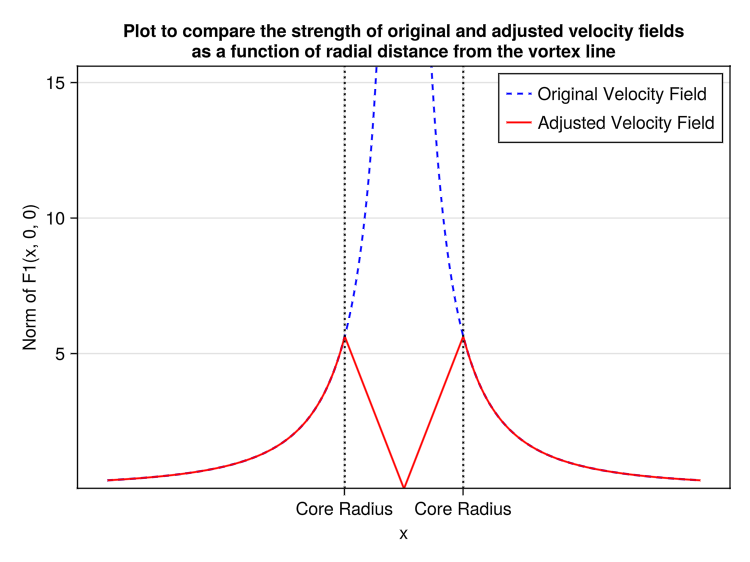

GLMakie.Screen(...)

In [259]:
core_radius = 1.0 # Define the core radius for the velocity field adjustment
F_adjusted(x,y,z) = velocity(Point3{Float64}(x, y, z), Point3{Float64}(0.0, 0.0, 0.0), Point3{Float64}(0.0, 0.0, 1.0), 100.0, core_radius)
x_vals = exponential_spacing(-5, 5, 1000; base=1)
y_vals = [norm(F1(x, 0, 0)) for x in x_vals]
y_adjusted = [norm(F_adjusted(x, 0, 0)) for x in x_vals]
padding = 10 # Padding for the y-axis limits

GLMakie.Makie.inline!(true)

fig = Figure()
ax = Axis(fig[1, 1],
    title="Plot to compare the strength of original and adjusted velocity fields\nas a function of radial distance from the vortex line",
    xlabel="x",
    ylabel="Norm of F1(x, 0, 0)",
    xticks = ([-core_radius, core_radius], ["Core Radius", "Core Radius"]),
    )

lines!(
    ax,
    x_vals, 
    y_vals ,
    label="Original Velocity Field",
    color=:blue,
    linestyle=:dash
    )

lines!(
    ax,
    x_vals,
    y_adjusted,
    label="Adjusted Velocity Field",
    color=:red)

axislegend()

# Plot a line parallel to the y-axis for x=±core_radius
vlines!(
    ax,
    [-core_radius, core_radius],
    linestyle=:dot,
    color=:black,
)

# Add x axis tick with label at core_radius
# Plot a point with a label on the x-axis at ± core_radius

ylims!(ax, minimum(y_adjusted), maximum(y_adjusted)+padding)

display(fig)

## Creating VortexLine and VortexLoop Structs

In [4]:
mutable struct VortexLine
    R1::AbstractVector{<:Real}  # Position of the first vortex
    R2::AbstractVector{<:Real}  # Position of the last vortex
    Gamma::Real                 # Circulation strength
    core_radius::Real           # Core radius for the velocity field adjustment
    
    # Inner constructor with validation
    function VortexLine(R1::AbstractVector{<:Real}, R2::AbstractVector{<:Real}, Gamma::Real, core_radius::Real=0.001)
        @assert length(R1) == 3 "Position vector R1 must be a 3D vector."
        @assert length(R2) == 3 "Position vector R2 must be a 3D vector."
        @assert core_radius >= 0 "Core radius must be non-negative."
        new(R1, R2, Gamma, core_radius)
    end
end

mutable struct VortexLoop
    vertices::Vector{<:AbstractVector{<:Real}}  # List of vertices defining the loop
    Gamma::Real                                 # Circulation strength
    core_radius::Real                           # Core radius for the velocity field adjustment
    direction::Real                             # Direction of the loop
    vortexlines::Vector{VortexLine}             # List of vortex lines forming the loop
end
# Define Constructors
function VortexLoop(vertices::Vector{<:AbstractVector{<:Real}}, Gamma::Real, core_radius::Real=0.001, direction::Real=1.0)
    @assert all(length(v) == 3 for v in vertices) "All vertices must be 3D vectors."
    @assert core_radius >= 0 "Core radius must be non-negative."
    @assert direction != 0 "The direction must define a sign (positive to traverse vertices in the order given, negative to traverse in the opposite order)."

    # Create vortex lines from the vertices
    vortexlines = Vector{VortexLine}()
    if direction > 0
        for i in 1:length(vertices)-1
            push!(vortexlines, VortexLine(vertices[i], vertices[i+1], Gamma, core_radius))
        end
        # Connect the last vertex to the first to close the loop
        push!(vortexlines, VortexLine(vertices[end], vertices[1], Gamma, core_radius))
    else
        for i in length(vertices):-1:2
            push!(vortexlines, VortexLine(vertices[i], vertices[i-1], Gamma, core_radius))
        end
        # Connect the first vertex to the last to close the loop
        push!(vortexlines, VortexLine(vertices[1], vertices[end], Gamma, core_radius))
    end
    return VortexLoop(vertices, Gamma, core_radius, direction, vortexlines)
end
function VortexLoop(vortexlines::Vector{VortexLine})
    vl_copy = deepcopy(vortexlines) # Create a copy of the vortex lines to avoid modifying the original
    # Make sure the vortex lines form a closed loop (i.e. for the entire vector, v[i].R2 == v[i+1].R1)
    @assert all(i -> vl_copy[i].R2 == vl_copy[i+1].R1, 1:length(vl_copy)-1) && vl_copy[end].R2 == vl_copy[1].R1 "Vortex lines must form a closed loop."
    
    # Make sure all vortex lines have the same circulation strength and core radius
    @assert all(vl -> vl.Gamma == vl_copy[1].Gamma, vl_copy) "All vortex lines must have the same circulation strength."
    @assert all(vl -> vl.core_radius == vl_copy[1].core_radius, vl_copy) "All vortex lines must have the same core radius."

    # Extract the vertices from the vortex lines
    vertices = [vl.R1 for vl in vl_copy]

    return VortexLoop(vertices, vl_copy[1].Gamma, vl_copy[1].core_radius, 1.0, vl_copy)
end

function _vertices_generator_radius(centre::AbstractVector{<:Real}, num_vertices::Int; radius::Real, angleoffset::Real=0.0, upvector::AbstractVector{<:Real}=[0.0, 0.0, 1.0])
    @assert length(centre) == 3 "Centre must be a 3D vector."
    @assert length(upvector) == 3 "Up vector must be a 3D vector."
    @assert radius > 0 "Radius must be a positive number."

    # Normalize the up vector
    up = normalize(upvector)
    
    # Create two orthonormal vectors in the plane perpendicular to upvector
    # Choose an arbitrary vector not parallel to up
    if abs(dot(up, [1.0, 0.0, 0.0])) < 0.9
        temp = [1.0, 0.0, 0.0]
    else
        temp = [0.0, 1.0, 0.0]
    end
    
    # Create first basis vector in the plane
    u1 = normalize(cross(up, temp))
    # Create second basis vector in the plane
    u2 = cross(up, u1)
    
    # Generate vertices in circular pattern
    vertices = Vector{Point{3, Float64}}()
    
    for i in 0:(num_vertices-1)
        angle = angleoffset + 2π * i / num_vertices - π/2  # Start at the [1,0,0] point by default
        
        # Calculate position in the plane
        local_pos = radius * (cos(angle) * u1 + sin(angle) * u2)
        
        # Translate to the centre
        vertex = centre + local_pos
        
        push!(vertices, vertex)
    end
    
    return vertices
end
function _vertices_generator_side(centre::AbstractVector{<:Real}, num_vertices::Int; side::Real, angleoffset::Real=0.0, upvector::AbstractVector{<:Real}=[0.0, 0.0, 1.0])
    @assert length(centre) == 3 "Centre must be a 3D vector."
    @assert length(upvector) == 3 "Up vector must be a 3D vector."
    @assert side > 0 "Side length must be a positive number."

    # Calculate vertex radial distance from centre if side length is given 
    radius = side / (2 * sin(π / num_vertices))  # Radius of the circumscribed circle for the polygon
    return vertices_generator(centre, num_vertices; radius=radius, angleoffset=angleoffset, upvector=upvector)
end

function vertices_generator(centre::AbstractVector{<:Real}, num_vertices::Int; side::Union{<:Real, Nothing}=nothing, radius::Union{<:Real, Nothing}=nothing, angleoffset::Real=0.0, upvector::AbstractVector{<:Real}=[0.0, 0.0, 1.0])
    @assert side === nothing || radius === nothing "Only one of side or radius can be provided."

    if side != nothing
        return _vertices_generator_side(centre, num_vertices; side=side, angleoffset=angleoffset, upvector=upvector)
    elseif radius != nothing
        return _vertices_generator_radius(centre, num_vertices; radius=radius, angleoffset=angleoffset, upvector=upvector)
    else
        # Use side=1.0 as default if neither side nor radius is provided
        return _vertices_generator_radius(centre, num_vertices; radius=1.0, angleoffset=angleoffset, upvector=upvector)
    end
end


vertices_generator (generic function with 1 method)

In [5]:
function set_Gamma!(loop::VortexLoop, new_Gamma::Real)
    loop.Gamma = new_Gamma
    for vortexline in loop.vortexlines
        vortexline.Gamma = new_Gamma
    end
end
function set_Gamma!(loops::Vector{VortexLoop}, new_Gamma::Union{<:Real, <:AbstractVector{<:Real}})
    if typeof(new_Gamma) <: Real
        for loop in loops
            set_Gamma!(loop, new_Gamma)
        end
    elseif typeof(new_Gamma) <: AbstractVector{<:Real}
        @assert length(new_Gamma) == length(loops) "The length of new_Gamma must match the number of loops."
        for (loop, gamma) in zip(loops, new_Gamma)
            set_Gamma!(loop, gamma)
        end
    else
        throw(ArgumentError("new_Gamma must be either a Real or an AbstractVector of Reals."))
    end
end

set_Gamma! (generic function with 2 methods)

In [6]:
function velocity(r::AbstractVector{<:Real}, vortexline::VortexLine)
    # Calculate the velocity at point r due to a single vortex line
    return velocity(r, vortexline.R1, vortexline.R2, vortexline.Gamma, vortexline.core_radius)
end
function velocity(r::AbstractVector{<:Real}, vortexloop::VortexLoop)
    # Calculate the total velocity at point r due to a vortex loop
    v_total = zeros(3)
    for vortexline in vortexloop.vortexlines
        v_total += velocity(r, vortexline)
    end
    return v_total
end

velocity (generic function with 4 methods)

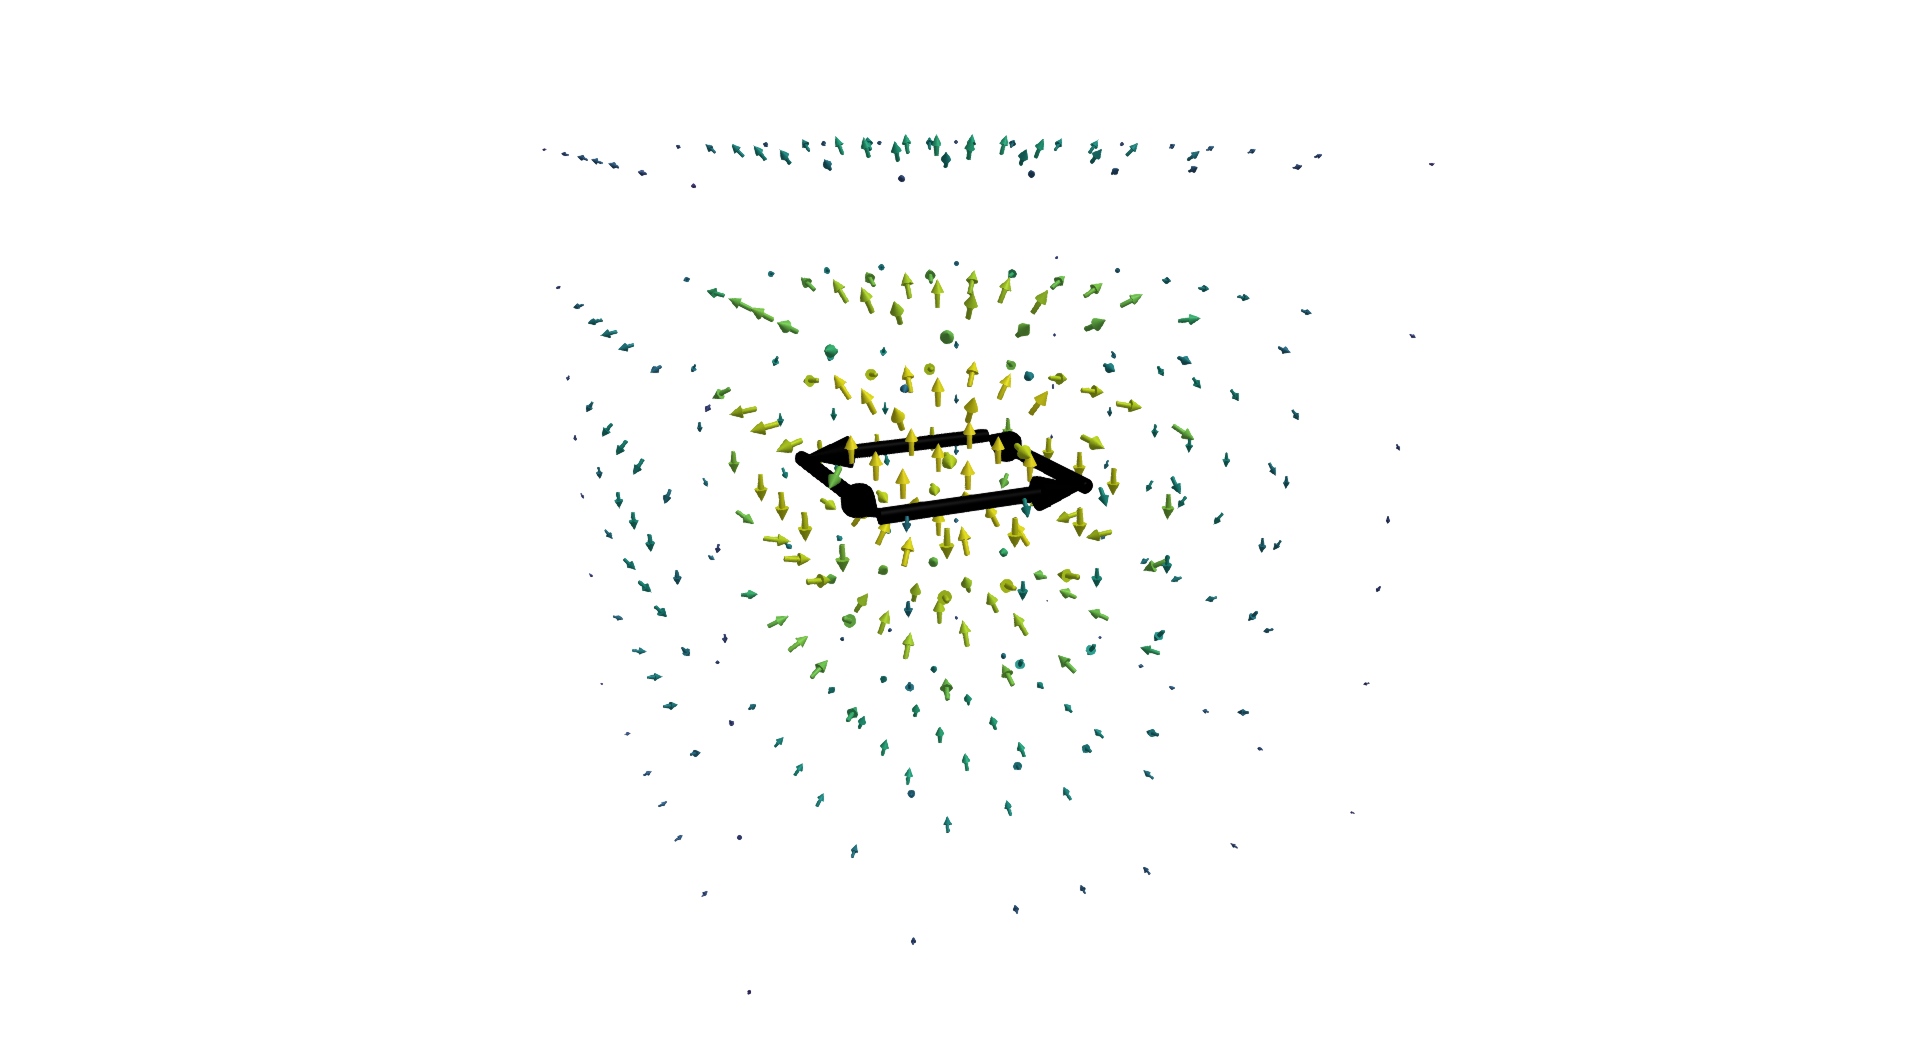

GLMakie.Screen(...)

In [73]:
GLMakie.Makie.inline!(false)

s = Scene(camera=cam3d!)
display(s)
v = vertices_generator([0.0, 0.0, 0.0], 4; radius=1.0, angleoffset=pi/4, upvector=[0.0, 0.0, 1.0])
loop = VortexLoop(v, 100.0, 0.05, 1.0)

for vortexline in loop.vortexlines
    meshscatter!(s, Point3(0.0,0.0,0.0), markersize=1, color=:black, marker=Arrow(vortexline.R1, vortexline.R2, shaft_radius=loop.core_radius).mesh)
end

# Visualize velocity field 
F(x,y,z) = velocity(Point3{Float64}(x, y, z), loop)
visualize_vector_field!(s, F, bounds=2, resolution=7, scale=0.2, base=3)


sleep(10) # Let user set the camera position before the script ends

GLMakie.Makie.inline!(true) # Re-enable inline rendering for subsequent plots
display(s) # Render the image inline 

## Simulate a Particle in air with the velocity vector field

In [115]:
function runge_kutta_4(F::Function, p0::AbstractVector{<:Real}, dt::Real, steps::Int, path::Observable{<:AbstractVector{<:Real}}, render_speed::Real=2.0)
    p = p0
    for _ in 1:steps
        k1 = F(p[1], p[2], p[3])
        k2 = F(p[1] + dt/2 * k1[1], p[2] + dt/2 * k1[2], p[3] + dt/2 * k1[3])
        k3 = F(p[1] + dt/2 * k2[1], p[2] + dt/2 * k2[2], p[3] + dt/2 * k2[3])
        k4 = F(p[1] + dt * k3[1], p[2] + dt * k3[2], p[3] + dt * k3[3])
        p += (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
        push!(path[], Point3{Float64}(p))
        notify(path)
        sleep(dt/render_speed) # Sleep for dt seconds to simulate time passing
    end
    nothing
end

GLMakie.Makie.inline!(false) # Disable inline rendering for the simulation

s = Scene(camera=cam3d!)
display(s)
v = vertices_generator([0.0, 0.0, 0.0], 4; radius=1.0, angleoffset=pi/4, upvector=[0.0, 0.0, 1.0])
loop = VortexLoop(v, 100.0, 0.05, 1.0)

for vortexline in loop.vortexlines
    meshscatter!(s, Point3(0.0,0.0,0.0), markersize=1, color=:black, marker=Arrow(vortexline.R1, vortexline.R2, shaft_radius=loop.core_radius).mesh)
end

# Visualize velocity field 
F(x,y,z) = velocity(Point3{Float64}(x, y, z), loop)
visualize_vector_field!(s, F, bounds=2, resolution=7, scale=0.2, base=3)



# Run an async loop to record everything into an mp4 file 

# Start recording BEFORE adding particles
framerate = 30  # Frames per second
recording = Observable(true)
io_ref = Ref{Any}(nothing)
filepath = joinpath(@__DIR__, "..Media/Videos/particles.mp4")


sleep(5)

p0 = Point3{Float64}(rand(3)) # Initial position
path = Observable([p0]) # Observable to store the path
meshscatter!(s, lift(path->path[end], path), markersize=0.05, color=:red, space=:data)
lines!(s, path; color=lift(path->length(path) > 1 ? [GLMakie.RGBA(1, 0, 0, i / (length(path)-1)) for i in 0:length(path)-1] : [GLMakie.RGBA(1, 0, 0, 1.0)], path), linewidth=5, space=:data, overdraw=true)

p1 = Point3{Float64}(rand(3)) # Initial position
path1 = Observable([p1]) # Observable to store the path
meshscatter!(s, lift(path->path[end], path1), markersize=0.05, color=:red, space=:data)
lines!(s, path1; color=lift(path->length(path) > 1 ? [GLMakie.RGBA(1, 0, 0, i / (length(path)-1)) for i in 0:length(path)-1] : [GLMakie.RGBA(1, 0, 0, 1.0)], path1), linewidth=5, space=:data, overdraw=true)

p2 = Point3{Float64}(rand(3)) # Initial position
path2 = Observable([p2]) # Observable to store the path
meshscatter!(s, lift(path->path[end], path2), markersize=0.05, color=:red, space=:data)
lines!(s, path2; color=lift(path->length(path) > 1 ? [GLMakie.RGBA(1, 0, 0, i / (length(path)-1)) for i in 0:length(path)-1] : [GLMakie.RGBA(1, 0, 0, 1.0)], path2), linewidth=5, space=:data, overdraw=true)

include("../src/Recorder.jl") # Import the recording utility functions
record_on_change_until(s, path2, recording, io_ref, filepath; framerate=framerate)


@async runge_kutta_4(F, p0, 0.001, 1000, path)
@async runge_kutta_4(F, p1, 0.001, 1000, path1)
@async runge_kutta_4(F, p2, 0.001, 1000, path2)


Task (runnable, started) @0x00000279d9b2df10

<video width="800" controls>
  <source src="../Media/Videos/particles.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>

---

## Finding Circulation Strength values from Penetration Condition



In [142]:
function prefactor(r::AbstractVector{<:Real}, R1::AbstractVector{<:Real}, R2::AbstractVector{<:Real}, core_radius::Real)
    #https://www.tfd.chalmers.se/~lada/postscript_files/Licentiate_thesis_Hamid.pdf
    @assert length(r) == 3 "Position vector r must be a 3D vector."
    @assert length(R1) == 3 "Position vector R1 must be a 3D vector."
    @assert length(R2) == 3 "Position vector R2 must be a 3D vector."

    R1r = r - R1
    R2r = r - R2

    K12 = dot(-1 * (R2 - R1) / (4 * pi * norm(cross(R1r, R2r))^2), (normalize(R2r) - normalize(R1r)))
    v = K12 * cross(R1r, R2r)

    # Apply core correction
    # If r is within the core_radius of the line Joining R1 and R2, assume a velocity to be a linear function of the radial distance in that direction (zero at norm(r)=0 and equal to the usual velocity at norm(r)=core_radius)

    function point_projection_on_line(point::AbstractVector{<:Real}, line_start::AbstractVector{<:Real}, line_end::AbstractVector{<:Real})
        # Project point onto the line defined by line_start and line_end
        line_dir = normalize(line_end - line_start)
        return line_start + dot(point - line_start, line_dir) * line_dir
    end

    distance_to_line = norm(r - point_projection_on_line(r, R1, R2))
    if distance_to_line < core_radius
        # Calculate the direction from the line to the point
        direction = normalize(r - point_projection_on_line(r, R1, R2))
        # Scale the prefactor by the ratio of distance to core radius
        v = v * (distance_to_line / core_radius)
    end

    return v
end

function prefactor(r::AbstractVector{<:Real}, vortexline::VortexLine)
    # Calculate the prefactor at point r due to a single vortex line
    return prefactor(r, vortexline.R1, vortexline.R2, vortexline.core_radius)
end
function prefactor(r::AbstractVector{<:Real}, vortexloop::VortexLoop)
    # Calculate the total prefactor at point r due to a vortex loop
    v_total = zeros(3)
    for vortexline in vortexloop.vortexlines
        v_total += prefactor(r, vortexline)
    end
    return v_total
end

prefactor (generic function with 3 methods)

In [8]:
loop = VortexLoop(vertices_generator([0.0, 0.0, 0.0], 4; radius=1.0, angleoffset=pi/4, upvector=[0.0, 0.0, 1.0]), 100.0, 0.05, 1.0)
f(x, y, z) = prefactor(Point3{Float64}(x, y, z), loop)
F(x,y,z) = velocity(Point3{Float64}(x, y, z), loop)

for i in 1:1000
    isapprox(f(i, i, i).*loop.Gamma, F(i, i, i))==true ? nothing : println("The prefactor and velocity functions do not match at point ($i, $i, $i).")
end

In [9]:
# Define Loops in the xy plane
n = 5

n_hat = [Point3{Float64}(0.0, 0.0, 1.0) for i in 1:n] # Normal vector for the loops
Gamma = [0 for i in 1:n] # Circulation strength for each loop (Initially set to zero)

loops = [
    VortexLoop(vertices_generator([0.0, 0.0, 0.0], 4; side=1.0, angleoffset=pi/4, upvector=n_hat[1]), Gamma[1], 0.05, 1.0)
    VortexLoop(vertices_generator([1.0, 0.0, 0.0], 4; side=1.0, angleoffset=pi/4, upvector=n_hat[1]), Gamma[1], 0.05, 1.0)
    VortexLoop(vertices_generator([-1.0, 0.0, 0.0], 4; side=1.0, angleoffset=pi/4, upvector=n_hat[1]), Gamma[1], 0.05, 1.0)
    VortexLoop(vertices_generator([0.0, 1.0, 0.0], 4; side=1.0, angleoffset=pi/4, upvector=n_hat[1]), Gamma[1], 0.05, 1.0)
    VortexLoop(vertices_generator([0.0, -1.0, 0.0], 4; side=1.0, angleoffset=pi/4, upvector=n_hat[1]), Gamma[1], 0.05, 1.0)
]

centroids = [sum(loop.vertices) / length(loop.vertices) for loop in loops]

v_w = rand(Point3{Float64}, n) # Desired velocity at the centroid of each loop
phi = zeros(Point3{Float64}, n) # Desired additive velocity vector due to known factors at the centroid of each loop

A = zeros(n,n)
for i in 1:n
    for j in 1:n
        A[i,j] = dot(prefactor(centroids[i], loops[j]), n_hat[i]) # Calculate the prefactor at the centroid of each loop
    end
end

b = [dot(v_w[i]-phi[i], n_hat[i]) for i in 1:n] # Calculate the right-hand side vector

Gamma = inv(A) * b # Solve for the circulation strengths

nothing

In [10]:
s = Scene(camera=cam3d!)
display(s)
for i in 1:n
    for vortexline in loops[i].vortexlines
        meshscatter!(s, Point3(0.0,0.0,0.0), markersize=1, color=:black, marker=Arrow(vortexline.R1, vortexline.R2, shaft_radius=loops[i].core_radius).mesh)
    end
end

In [11]:
set_Gamma!(loops, Gamma)
F(x,y,z) = sum(velocity(Point3{Float64}(x, y, z), loop) for loop in loops)

F (generic function with 1 method)

In [12]:
visualize_vector_field!(s, F, bounds=2, resolution=7, scale=0.5, base=3)
nothing

In [13]:
[F(centroid[1], centroid[2], centroid[3]) for centroid in centroids] # Check the velocity at the centroids of the loops

5-element Vector{Point{3, Float64}}:
 [0.0, 0.0, 0.5718301424882242]
 [0.0, 0.0, 0.8958809215110617]
 [0.0, 0.0, 0.4723891926720904]
 [0.0, 0.0, 0.7752840392352275]
 [0.0, 0.0, 0.5373797775159354]

In [14]:
v_w

5-element Vector{Point{3, Float64}}:
 [0.4175996767803296, 0.05730838464068766, 0.571830142488224]
 [0.8733888926280805, 0.6520832088066095, 0.8958809215110618]
 [0.36772287879622156, 0.8785796771487205, 0.47238919267209034]
 [0.422086266326935, 0.4207080429802246, 0.7752840392352274]
 [0.10901644867096993, 0.49989836819540423, 0.5373797775159356]

The z component of both vectors are the same. Since $\hat{n}$ for this case is $[0,0,1]$, the Non-Penetration Condition is met!

---

### General Example of Non-Penetration Condition

In [15]:
# Define n random loops
n = 5

# Generate random positions for loop centers
centers = [rand(1:sqrt(n))*Point3{Float64}(randn(3)...) for i in 1:n]  # Random centers with normal distribution
# Or use uniform distribution in a specific range:
# centers = [Point3{Float64}((rand(3) .- 0.5) .* 4) for i in 1:n]  # Centers in [-2, 2] range

# Generate random normal vectors for each loop
n_hat = [normalize(Point3{Float64}(randn(3)...)) for i in 1:n]  # Random unit normal vectors

# Generate random geometric parameters
sides = rand(0.5:0.1:2.0, n)  # Random side lengths between 0.5 and 2.0
num_vertices = rand(3:8, n)   # Random number of vertices between 3 and 8
angle_offsets = rand(0:0.1:2π, n)  # Random angle offsets

Gamma = [0 for i in 1:n] # Circulation strength for each loop (Initially set to zero)

# Create random loops
loops = [VortexLoop(
    vertices_generator(
        centers[i], 
        num_vertices[i]; 
        side=sides[i], 
        angleoffset=angle_offsets[i], 
        upvector=n_hat[i]
    ), 
    Gamma[i], 
    0.05, 
    1.0
) for i in 1:n]

5-element Vector{VortexLoop}:
 VortexLoop(Point{3, Float64}[[-0.8767751072622464, -1.5055281945518437, -0.5756521550277919], [-0.6053262230099289, -2.148234492633673, -0.5186949988125902], [-0.40153201089737284, -1.727104792338601, -1.0393846325089076]], 0, 0.05, 1.0, VortexLine[VortexLine([-0.8767751072622464, -1.5055281945518437, -0.5756521550277919], [-0.6053262230099289, -2.148234492633673, -0.5186949988125902], 0, 0.05), VortexLine([-0.6053262230099289, -2.148234492633673, -0.5186949988125902], [-0.40153201089737284, -1.727104792338601, -1.0393846325089076], 0, 0.05), VortexLine([-0.40153201089737284, -1.727104792338601, -1.0393846325089076], [-0.8767751072622464, -1.5055281945518437, -0.5756521550277919], 0, 0.05)])
 VortexLoop(Point{3, Float64}[[2.171148983360421, 1.39695381461107, -0.09139415048659498], [1.7402268034688022, 0.5874752380003841, -1.012833518478756], [0.47115959340192315, 0.3197890216619419, -1.1012218995900747], [-0.36698543677333595, 0.8615813819341864, -0.26817

In [16]:
centroids = [sum(loop.vertices) / length(loop.vertices) for loop in loops]

v_w = rand(Point3{Float64}, n) # Desired velocity at the centroid of each loop
phi = zeros(Point3{Float64}, n) # Desired additive velocity vector due to known factors at the centroid of each loop

A = zeros(n,n)
for i in 1:n
    for j in 1:n
        A[i,j] = dot(prefactor(centroids[i], loops[j]), n_hat[i]) # Calculate the prefactor at the centroid of each loop
    end
end

b = [dot(v_w[i]-phi[i], n_hat[i]) for i in 1:n] # Calculate the right-hand side vector

Gamma = inv(factorize(A)) * b # Solve for the circulation strengths

nothing

In [17]:
set_Gamma!(loops, Gamma)
F(x,y,z) = sum(velocity(Point3{Float64}(x, y, z), loop) for loop in loops)

F (generic function with 1 method)

In [18]:
# Visualize 
s = Scene(camera=cam3d!)
display(s)
for i in 1:n
    for vortexline in loops[i].vortexlines
        meshscatter!(s, Point3(0.0,0.0,0.0), markersize=1, color=:black, marker=Arrow(vortexline.R1, vortexline.R2).mesh)
    end
    visualize_vector_field!(s, F; bounds=norm(loops[i].vertices[1]-centroids[i]).*2, resolution=7, scale=0.5, base=3, center=centroids[i])
end


# Check normalization condition is met 

for i in eachindex(centroids)
    centroid = centroids[i]
    if isapprox(dot(F(centroid[1], centroid[2], centroid[3]), n_hat[i]) , dot(v_w[i], n_hat[i]))
        println("(SUCCESS)")
    else
        println("(FAILURE)")
    end
    # Print out the n_hat, v_w, and F values for debugging
    println("n_hat: ", n_hat[i], "\nv_w: ", v_w[i], "\nF: ", F(centroid[1], centroid[2], centroid[3]), "\ndot(F, n_hat): ", dot(F(centroid[1], centroid[2], centroid[3]), n_hat[i]), "\ndot(v_w, n_hat): ", dot(v_w[i], n_hat[i]))
    println("--------------------------------------------------")
end

(SUCCESS)
n_hat: [0.7320899369539796, 0.36042718654506084, 0.5780454717493512]
v_w: [0.7739043467971297, 0.05727112915019761, 0.5006016153898791]
F: [0.23182716475793208, 0.11468458002654369, 1.1513391435564682]
dot(F, n_hat): 0.876580153331516
dot(v_w, n_hat): 0.876580153331516
--------------------------------------------------
(SUCCESS)
n_hat: [-0.11964345388037835, 0.7729524231785453, -0.6230810504629304]
v_w: [0.883319513794523, 0.17954784927852374, 0.11978403331103582]
F: [0.11773002480565564, 0.06664437664321937, 0.12673137660641404]
dot(F, n_hat): -0.0415366136381089
dot(v_w, n_hat): -0.04153661363810891
--------------------------------------------------
(SUCCESS)
n_hat: [-0.20716992822365785, 0.27499987360728995, 0.9388587169301774]
v_w: [0.3977235375880155, 0.2706664705214892, 0.7087802921633701]
F: [-0.12950642558187878, 0.18168180464397296, 0.6185053442616317]
dot(F, n_hat): 0.6574814441340704
dot(v_w, n_hat): 0.6574814441340704
----------------------------------------------

---

# Tiling a Wing with Vortex Loops and Computing the Circulation Strength

In [143]:
# From dragonfly.jl:

println("Loading packages...")
using GLMakie, GeometryBasics, LinearAlgebra, Quaternions, FileIO
import Quaternions: Quaternion as Quaternion
println("Packages loaded successfully.")

cd(@__DIR__) # Changing the current working directory from project root to the parent directory of this file so that pwd() and @__DIR__ match.
# Import custom code and utility functions
include("../src/State_and_Conversions.jl")
include("../src/Rendering.jl")
include("../src/Transformations.jl")
include("../src/WindowManager.jl")
include("../src/Recorder.jl")



# Initialize the custom structs and utilities
conversions = Conversions()
renderer = Renderer()
transformations = Transformations()
windowmanager = WindowManager()

println("Custom structs and utilities initialized successfully.")

# Defining Custom Mesh Transformation functions
function translate_obj(obj::AbstractMesh, translation::AbstractVector)
    obj_copy = deepcopy(obj)  # Create a copy of the object to avoid modifying the original
    # Translate positions
    for i in eachindex(obj_copy.vertex_attributes[1])
        obj_copy.vertex_attributes[1][i] += translation
    end

    # Translate normals if they exist
    if length(obj_copy.vertex_attributes) >= 3
        for i in eachindex(obj_copy.vertex_attributes[3])
            obj_copy.vertex_attributes[3][i] += translation
        end
    end

    return obj_copy
end

function rotate_obj(obj::AbstractMesh, R::AbstractMatrix; about::Union{AbstractVector,Nothing}=nothing)
    obj_copy = deepcopy(obj)  # Create a copy of the object to avoid modifying the original
    # First translate the object to the origin
    if isnothing(about)
        # If no specific point is given, just rotate the object
        # Rotate positions
        for i in eachindex(obj.vertex_attributes[1])
            obj_copy.vertex_attributes[1][i] = Point3f(R * Vec3f(obj_copy.vertex_attributes[1][i]))
        end

        # Rotate normals if they exist
        if length(obj_copy.vertex_attributes) >= 3
            for i in eachindex(obj_copy.vertex_attributes[3])
                obj_copy.vertex_attributes[3][i] = normalize(Point3f(R * Vec3f(obj_copy.vertex_attributes[3][i])))
            end
        end

        return obj_copy
    else
        # If a specific point is given, translate the object to that point, rotate it, and then translate it back
        translation = -about
        obj_copy = translate_obj(obj_copy, translation)  # Translate to origin
        obj_copy = rotate_obj(obj_copy, R)  # Rotate around the origin
        obj_copy = translate_obj(obj_copy, -translation)  # Translate back to the original position

        return obj_copy
    end
end

function attach2State(obj::AbstractMesh, state_obs::Observable{State})
    return lift(st -> rotate_obj(obj, conversions.quat2rotmatrix(st.q)), state_obs)
end

#Load _models
_wing_model = load("../Models/DragonFly/FrontRight.stl") # Load the shader for the body
_wing_model = GeometryBasics.mesh(_wing_model)
_wing_model = translate_obj(_wing_model, Point3{Float64}(0.45,-0.25,-0.35)) # Translate the model to the origin
_wing_model = rotate_obj(_wing_model, conversions.axisangle2rotmatrix([1,0,0], -pi/20))
_wing_model = rotate_obj(_wing_model, conversions.axisangle2rotmatrix([0,1,0], -pi/40)) # Rotate the model to face the correct direction
# Define Positions
wing_pos = Observable(Point3(0.0, 0.0, 0.0)) # Observable for the wing position

# Define State Observables
wing = Observable(State()) # Create an observable state for the body

# Attach the models to the state observables with fixed _models
wing_model = attach2State(_wing_model, wing)

println("Models and positions defined successfully.")

# Create a scene for the DragonFly
set_theme!(theme_dark()) # Set the theme for the scene
s = Scene(camera=cam3d!, size=(500, 500))
drawState!(s)
wing_mesh = meshscatter!(s, wing_pos, marker=wing_model, markersize=1) # Add the body position to the scene



display(s) # Display the scene

println("Wing scene created successfully.")

Loading packages...
Packages loaded successfully.
Custom structs and utilities initialized successfully.
Models and positions defined successfully.
Wing scene created successfully.


In [119]:
transformations.interpolate_states(wing, State(conversions.axisangle2quat([1, 0, 0], 0)), rate_function=t->sin(t*pi/2)) # Rotate the front left wing by 45 degrees around the y-axis

In [144]:
wing_vertices = lift(wing_model -> wing_model.vertex_attributes[1], wing_model) # Get the vertices of the wing model
wing_face_indices = lift(wing_model -> wing_model.faces, wing_model)

function get_wing_loop(wing_vertices, wing_face_indices)
    wing_loops = VortexLoop[]
    for i in 1:length(wing_face_indices)
        face = wing_face_indices[i]
        vertices = [wing_vertices[face[j]] for j in 1:length(face)]
        push!(wing_loops, VortexLoop(vertices, 0.0, 0.001, 1.0)) # Create a vortex loop for each face of the wing
    end
    return wing_loops
end

wing_loops = lift((wing_vertices, wing_face_indices) -> get_wing_loop(wing_vertices, wing_face_indices), wing_vertices, wing_face_indices)


Observable(VortexLoop[VortexLoop(Point{3, Float32}[[-0.8024027, 2.5358453, -0.0231456], [0.84835005, 2.8732915, -0.009963529], [0.54005057, 4.262058, -0.025663635]], 0.0, 0.001, 1.0, VortexLine[VortexLine(Float32[-0.8024027, 2.5358453, -0.0231456], Float32[0.84835005, 2.8732915, -0.009963529], 0.0, 0.001), VortexLine(Float32[0.84835005, 2.8732915, -0.009963529], Float32[0.54005057, 4.262058, -0.025663635], 0.0, 0.001), VortexLine(Float32[0.54005057, 4.262058, -0.025663635], Float32[-0.8024027, 2.5358453, -0.0231456], 0.0, 0.001)]), VortexLoop(Point{3, Float32}[[-0.8024027, 2.5358453, -0.0231456], [0.54005057, 4.262058, -0.025663635], [-0.85668707, 3.680125, -0.0341145]], 0.0, 0.001, 1.0, VortexLine[VortexLine(Float32[-0.8024027, 2.5358453, -0.0231456], Float32[0.54005057, 4.262058, -0.025663635], 0.0, 0.001), VortexLine(Float32[0.54005057, 4.262058, -0.025663635], Float32[-0.85668707, 3.680125, -0.0341145], 0.0, 0.001), VortexLine(Float32[-0.85668707, 3.680125, -0.0341145], Float32[-0.

In [145]:
#Visualize wing_loops
function get_arrows(wing_loops)
    arrows = []
    for loop in wing_loops
        for vortexline in loop.vortexlines
            push!(arrows, Arrow(vortexline.R1, vortexline.R2))
        end
    end
    return arrows
end

arrows = lift(wing_loops -> get_arrows(wing_loops), wing_loops)

for i in eachindex(arrows[])
        color = rand(GLMakie.RGB) # Generate a random color for the wing loops
    meshscatter!(s, Point3(0.0,0.0,0.0), markersize=1, color=color, marker=lift(arrows->arrows[i].mesh, arrows), space=:data)
end

In [146]:
axis = [1.0, 0.0, 0.0] # Axis of rotation for the wing

A_omega = 2
phi_omega = 0.0
k_omega = 4.0

dt = 0.01 # Time step for the Runge-Kutta method

t = Observable(0.0) # Time observable for the oscillation

# omega(t) = A_omega*(1-cos(k_omega*t*pi))/2 + phi_omega
omega(t) = A_omega*cos(k_omega * t * pi/2) + phi_omega

theta = Observable(0.0)

# theta updater using runge_kutta_4
# Corrected RK4 integration for angular velocity
function calc_dtheta(t, dt)
    # RK4 for dθ/dt = ω(t)
    k1 = omega(t)
    k2 = omega(t + dt/2)
    k3 = omega(t + dt/2) 
    k4 = omega(t + dt)
    return (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
end



wing_state_updater = on(t) do t_val
    # Update the wing state based on the current time
    wing[] = State(conversions.axisangle2quat([1,0,0], calc_dtheta(t_val, dt)) * wing[].q) # The reason you would want to use this is so that you can have seperate thetas
    # If using multiple axis, you can combine the rotations into an effective quaternion (which means your angular velocity would be the angle theta_eff for the axis_eff of the effective rotation)
end

theta_updater = on(t) do t_val # Calculate the new theta as well
    theta[] += calc_dtheta(t_val, dt) # Update theta
end

# Calculate velocity of the wing each centroid of the wing loops
function calculate_wing_velocity(point, axis, omega)
    # Calculate the velocity of the wing at a given point based on the angular velocity
    # For rigid body rotation: v = ω × r, where r is the position vector from rotation center
    r = point - wing_pos[]  # Vector from rotation center to the point
    return cross(omega * axis, r)  # ω is scalar, axis is direction, so ω⃗ = ω * axis
end
function calculate_wing_velocity_at_centroids(wing_loops, axis, omega)
    velocities = []
    centroids = []
    for loop in wing_loops[]
        centroid = sum(loop.vertices) / length(loop.vertices)  # Calculate the centroid of the loop
        push!(velocities, calculate_wing_velocity(centroid, axis, omega))  # Calculate velocity at the centroid
        push!(centroids, centroid)  # Store the centroid
    end
    return centroids, velocities
end

wing_velocity_tuples = lift((t) -> calculate_wing_velocity_at_centroids(wing_loops, axis, omega(t)), t)

Observable((Any[Float32[0.19533265, 3.2237313, -0.019590922], Float32[-0.37301305, 3.492676, -0.027641244], Float32[-0.25058743, 1.6884757, -0.009983852], Float32[0.24078856, 2.2684367, -0.010432396], Float32[-0.15969953, 0.64136237, 0.0004593044], Float32[0.16348746, 0.9902584, 0.00046104786], Float32[-0.10509839, 0.09251379, 0.006001795], Float32[0.12446687, 0.26027688, 0.0067331493], Float32[-0.19744116, 5.0790086, -0.040376764], Float32[-0.5290444, 4.4775424, -0.03815852], Float32[-0.44188967, 6.143394, -0.052489895], Float32[-0.73561627, 5.857151, -0.052772895]], Any[[-0.0, 0.039181843400001526, 6.447462558746338], [-0.0, 0.05528248846530914, 6.985352039337158], [-0.0, 0.01996770314872265, 3.3769514560699463], [-0.0, 0.02086479216814041, 4.5368733406066895], [0.0, -0.000918608799111098, 1.2827247381210327], [0.0, -0.0009220957290381193, 1.980516791343689], [0.0, -0.012003590352833271, 0.1850275844335556], [0.0, -0.013466298580169678, 0.5205537676811218], [-0.0, 0.08075352758169174

In [147]:
# Visualize Velocity Field of Air 
function calculate_Gamma(wing_loops, wing_velocity_tuples)
    # Calculate the circulation strengths for the vortex loops based on the desired velocities at their centroids
    num_loops = length(wing_loops) # Number of loops
    @assert num_loops > 0 "There must be at least one vortex loop to calculate circulation strengths."
    centroids, v_w = wing_velocity_tuples
    phi = zeros(Point3{Float64}, num_loops) # Desired additive velocity vector due to known factors at the centroid of each loop
    function calculate_normal_vector(loop::VortexLoop)
        # Calculate the normal vector for the loop based on its vertices
        @assert length(loop.vertices) >= 3 "Loop must have at least 3 vertices to define a plane."
        v1 = loop.vertices[2] - loop.vertices[1]
        v2 = loop.vertices[3] - loop.vertices[1]
        n = normalize(cross(v1, v2))  # Normal vector using cross product
        return n
    end
    n_hat = [calculate_normal_vector(loop) for loop in wing_loops] # Normal vector for each loop

    A = zeros(num_loops,num_loops)
    for i in 1:num_loops
        for j in 1:num_loops
            A[i,j] = dot(prefactor(centroids[i], wing_loops[j]), n_hat[i]) # Calculate the prefactor at the centroid of each loop
        end
    end

    b = [dot(v_w[i]-phi[i], n_hat[i]) for i in 1:num_loops] # Calculate the right-hand side vector

    Gamma = inv(factorize(A)) * b # Solve for the circulation strengths

    return Gamma
end

calculate_Gamma (generic function with 1 method)

In [148]:
function arrows_at_centroids!(s, wing_velocity_tuples, F)
    # Create arrows at the centroids of the vortex loops based on the calculated velocities
    centroids, velocities = wing_velocity_tuples
    ms = []
    for i in eachindex(centroids)
        color = :red # Generate a random color for the arrows
        m = meshscatter!(s, Point3(0.0,0.0,0.0), markersize=1, color=color, marker=Arrow(centroids[i], Vec3(F(centroids[i]...))).mesh, space=:data)
        push!(ms, m) # Store the meshscatter object for later use
    end
    return ms
end

arrows_at_centroids! (generic function with 1 method)

In [149]:
global F(x,y,z) = sum(velocity(Point3{Float64}(x, y, z), wing_loop) for wing_loop in wing_loops[])
global field_vectors = arrows_at_centroids!(s, wing_velocity_tuples[], F) # Create arrows at the centroids of the vortex loops based on the calculated velocities
# global air_velocity_vectors = visualize_vector_field!(s, F; bounds=2, resolution=5, scale=0.5, base=3, center=Point3{Float64}(wing_velocity_tuples[][1][5]))
nothing

In [150]:
velocity_field_updater = on(wing_velocity_tuples) do wvt
    # Update the velocity field based on the circulation strengths
    for field_vector in field_vectors
        delete!(s, field_vector)  # Fixed: use field_vector instead of undefined i
    end
    
    Gamma = calculate_Gamma(wing_loops[], wvt)
    set_Gamma!(wing_loops[], Gamma)  # Set the circulation strengths for the loops
    notify(wing_loops)  # Notify the observers of the change
    
    # Redefine the global F function using eval
    eval(:(global F(x,y,z) = sum(velocity(Point3{Float64}(x, y, z), loop) for loop in $(wing_loops[]))))
    
    global field_vectors = arrows_at_centroids!(s, wvt, F) # Create arrows at the centroids of the vortex loops based on the calculated velocities
    # global air_velocity_vectors = visualize_vector_field!(s, F; bounds=2, resolution=5, scale=0.5, base=3, center=Point3{Float64}(wing_velocity_tuples[][1][5]))
    nothing
end

ObserverFunction defined at d:\Programming\Flapping Wing Flying Research\Demos-and-Tutorials\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y113sZmlsZQ==.jl:3 operating on Observable((Any[Float32[0.195333, 3.22373, -0.0195909], Float32[-0.373013, 3.49268, -0.0276412], Float32[-0.250587, 1.68848, -0.00998385], Float32[0.240789, 2.26844, -0.0104324], Float32[-0.1597, 0.641362, 0.000459304], Float32[0.163487, 0.990258, 0.000461048], Float32[-0.105098, 0.0925138, 0.0060018], Float32[0.124467, 0.260277, 0.00673315], Float32[-0.197441, 5.07901, -0.0403768], Float32[-0.529044, 4.47754, -0.0381585], Float32[-0.44189, 6.14339, -0.0524899], Float32[-0.735616, 5.85715, -0.0527729]], Any[[-0.0, 0.0391818, 6.44746], [-0.0, 0.0552825, 6.98535], [-0.0, 0.0199677, 3.37695], [-0.0, 0.0208648, 4.53687], [0.0, -0.000918609, 1.28272], [0.0, -0.000922096, 1.98052], [0.0, -0.0120036, 0.185028], [0.0, -0.0134663, 0.520554], [-0.0, 0.0807535, 10.158], [-0.0, 0.076317, 8.95508], [-0.0, 0.10498, 12.2868], [-

In [151]:
n = 100
dt = 1/n # Time step for the Runge-Kutta method
for i in 1:2n
    t[] = t[] + dt # Update the time observable
    # sleep(dt) # Sleep for a short duration to simulate time passing
    println(i/n)
    yield() # Yield control to allow other tasks to run
end

0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
Direction vector has zero length, picking default direction for a small arrow.
Direction vector has zero length, picking default direction for a small arrow.
Direction vector has zero length, picking default direction for a small arrow.
Direction vector has zero length, picking default direction for a small arrow.
Direction vector has zero length, picking default direction for a small arrow.
Direction vector has zero length, picking default direction for a small arrow.
Direction vector has zero length, picking default direction for a small arrow.
Direction vector has zero length, picking default direction for a small arrow.
Direction vector has zero length, picking default direction for a small arrow.
Direction vector has zero length, picking default direction for a small arrow.
Direction vector has zero length, picking default direction for a small arrow.
Directio

In [152]:
# # p = plot(lift(t->[omega(t)], t))
# # plot!(p.axis, lift(theta->[theta], theta))

# fig = Figure()
# ax = Axis(fig[1, 1], title="Oscillation of the Wing")
# ylims!(ax, -1, 1)
# plot!(ax, lift(t->[omega(t)], t))
# plot!(ax, lift(theta->[theta], theta), color=:red)
# display(fig)

In [153]:
# Check Penetration condition
function calculate_normal_vector(loop::VortexLoop)
        # Calculate the normal vector for the loop based on its vertices
        @assert length(loop.vertices) >= 3 "Loop must have at least 3 vertices to define a plane."
        v1 = loop.vertices[2] - loop.vertices[1]
        v2 = loop.vertices[3] - loop.vertices[1]
        n = normalize(cross(v1, v2))  # Normal vector using cross product
        return n
    end
n_hat = [calculate_normal_vector(loop) for loop in wing_loops[]] # Normal vector for each loop
centroids, v_w = wing_velocity_tuples[]

for i in eachindex(centroids)
    centroid = centroids[i]
    if isapprox(dot(F(centroid[1], centroid[2], centroid[3]), n_hat[i]) , dot(v_w[i], n_hat[i]), atol=1e-6)
    # if isapprox(dot(velocity(centroid, wing_loops[][i]), n_hat[i]), dot(v_w[i], n_hat[i]), atol=1e-6)
        println("(SUCCESS)")
    else
        println("(FAILURE)")
    end
    # Print out the n_hat, v_w, and F values for debugging
    println("n_hat: ", n_hat[i], "\nv_w: ", v_w[i], "\nF: ", F(centroid[1], centroid[2], centroid[3]), "\ndot(F, n_hat): ", dot(F(centroid[1], centroid[2], centroid[3]), n_hat[i]), "\ndot(v_w, n_hat): ", dot(v_w[i], n_hat[i]))
    println("--------------------------------------------------")
end

(SUCCESS)
n_hat: Float32[-0.00984861, 0.009117711, 0.9999099]
v_w: [-0.0, 0.039181843400001526, 6.447462558746338]
F: [-0.0634963632683783, 0.0587837823803893, 6.446658103813635]
dot(F, n_hat): 6.447238441104725
dot(v_w, n_hat): 6.447238747826187
--------------------------------------------------
(SUCCESS)
n_hat: Float32[-0.009848688, 0.009117772, 0.99990994]
v_w: [-0.0, 0.05528248846530914, 6.985352039337158]
F: [-0.06879515341613499, 0.06368890396903183, 6.984597625864857]
dot(F, n_hat): 6.985226817600334
dot(v_w, n_hat): 6.985226973361367
--------------------------------------------------
(SUCCESS)
n_hat: Float32[-0.009848509, 0.009117633, 0.99990994]
v_w: [-0.0, 0.01996770314872265, 3.3769514560699463]
F: [-0.03325668221664449, 0.03078855993716878, 3.376524537940572]
dot(F, n_hat): 3.376828686826982
dot(v_w, n_hat): 3.3768293771713367
--------------------------------------------------
(SUCCESS)
n_hat: Float32[-0.009848575, 0.009117546, 0.9999098]
v_w: [-0.0, 0.02086479216814041, 4.

In [154]:
# Plot the velocities of points on the wing at centroids using wing_velocity_tuples
centroids, v_w = wing_velocity_tuples[]
wing_speed_mesh = []
for i in eachindex(centroids)
    m = meshscatter!(s, Point3(0.0,0.0,0.0), markersize=1, color=:blue, marker=Arrow(Point3{Float64}(centroids[i]), Vec3{Float64}(v_w[i])).mesh, space=:data)
    push!(wing_speed_mesh, m) # Store the meshscatter object for later use
end

In [155]:
wing_center = sum(centroids) / length(centroids) # Calculate the center of the wing loops

# Visualize the velocity field at the center of the wing loops
air_field_mesh = visualize_vector_field!(s, F; bounds=3, resolution=10, scale=1, base=1, center=Point{3, Float64}(wing_center), normalization_condition=true)
nothing

In [156]:
for i in eachindex(wing_speed_mesh)
    delete!(s, wing_speed_mesh[i])  # Delete the old speed mesh
end

for i in eachindex(field_vectors)
    delete!(s, field_vectors[i])  # Delete the old field vectors
end

In [157]:
for i in eachindex(air_field_mesh)
    delete!(s, air_field_mesh[i])  # Delete the previous air field mesh
end

In [158]:
F_diff_wing_air(x,y,z) = F(x,y,z) - calculate_wing_velocity(Point3{Float64}(x, y, z), axis, omega(t[])) # Plot the relative velocity field of the air with respect to the wing

F_diff_wing_air (generic function with 1 method)

In [161]:
diff_field_mesh = visualize_vector_field!(s, F_diff_wing_air; bounds=[1.5,3,0.5], resolution=[10,20,10], scale=0.2, base=1, center=Point{3, Float64}(wing_center), normalization_condition=true)
nothing

In [160]:
for i in eachindex(diff_field_mesh)
    delete!(s, diff_field_mesh[i])  # Delete the previous air field mesh
end